In [1]:
# A Validation Set during training
# Solve overfitting (early stopping)
# Training Error down, but Validation Error up

# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

In [2]:
print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow version 1.13.1
Pandas version 0.24.2
Numpy version 1.16.2


In [4]:
# Function to Model
# y = a * x^4 + b
# Let's generate 1000 random samples
pool = np.random.rand(1000,1).astype(np.float32)
# Shuffle the samples
np.random.shuffle(pool)
# sample size of 15%
sample = int(1000 * 0.15)
# 15% test
test_x = pool[0:sample]
# 15% validation
valid_x = pool[sample:sample*2]
# 70% training
train_x = pool[sample*2:]
print('Testing data points: ' + str(test_x.shape))
print('Validation data points: ' + str(valid_x.shape))
print('Training data points: ' + str(train_x.shape))
# Let's compute the ouput using 2 for a, 5 for b
test_y = 2.0 * test_x**4 + 5
valid_y = 2.0 * valid_x**4 + 5
train_y = 2.0 * train_x**4 + 5

Testing data points: (150, 1)
Validation data points: (150, 1)
Training data points: (700, 1)


In [5]:
df = pd.DataFrame({'x':train_x[:,0],'y':train_y[:,0]})
df.head()

,x,y
0,0.548229,5.180667
1,0.040867,5.000006
2,0.261794,5.009394
3,0.036003,5.000003
4,0.361197,5.034041


In [6]:


df.describe()



,x,y
count,700.000000,700.000000
mean,0.491436,5.390879
std,0.289726,0.534863
min,0.001313,5.000000
25%,0.252377,5.008115
50%,0.465265,5.093720
75%,0.747711,5.625123
max,0.999622,6.996976


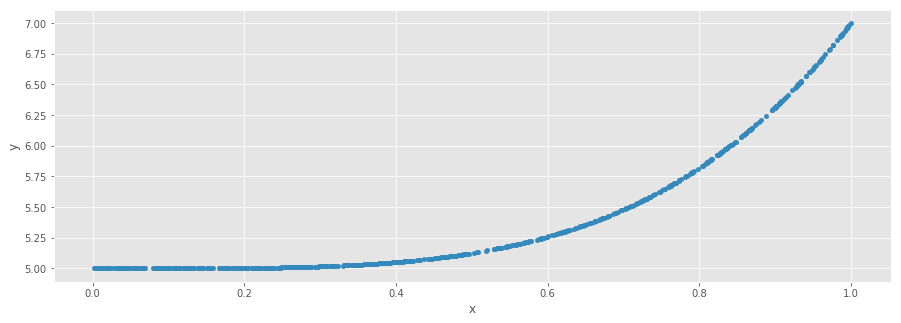

In [9]:
df.plot.scatter(x='x', y='y', figsize=(15,5));

In [10]:
# Helper Function
def add_layer(inputs, in_size, out_size, activation_function=None):
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

In [11]:
# Model your Graph
# you can adjust the number of neurons in the hidden layers here
hidden_size = 100
# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")
print("shape of x and y:")
print(x.get_shape(),y.get_shape())

shape of x and y:
(?, 1) (?, 1)


In [12]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)
h2 = add_layer(h1, hidden_size, hidden_size, tf.nn.relu)

print("shape of hidden layers:")
print(h1.get_shape(), h2.get_shape())

Instructions for updating:
Colocations handled automatically by placer.
shape of hidden layers:
(?, 100) (?, 100)


In [13]:
# Output Layers
pred = add_layer(h2, hidden_size, 1)
print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [14]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))
# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.005)
train = optimizer.minimize(loss)

In [15]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
# Set Up Your Early Stoppage Variables
# Best validation accuracy seen so far.
best_valid_acc = 0.0
# Iteration-number for last improvement to validation accuracy.
last_improvement = 0
# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

In [17]:
# initialize the variables
init = tf.global_variables_initializer()
# hold step and error values
t = []
# Run your graph
with tf.Session() as sess:
    # initialize variables
    sess.run(init)
    # Fit the function.
    for step in range(6000):
        # get your data
        train_data = {x:train_x, y:train_y}
        valid_data = {x:valid_x, y:valid_y}
        test_data = {x:test_x, y:test_y}
        # training in progress...
        train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
        # print every n iterations
        if step%100==0:
            # capture the step and error for analysis
            valid_loss = sess.run(loss, feed_dict=valid_data) 
            t.append((step, train_loss, valid_loss))    
            # get snapshot of current training and validation accuracy       
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)           
            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_valid_acc:
                # Update the best-known validation accuracy.
                best_valid_acc = valid_acc
                # Set the iteration for the last improvement to current.
                last_improvement = step
                # Flag when ever an improvement is found
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''   
            print("Training loss at step %d: %f %s" % (step, train_loss, improved_str))        
            print("Validation %f" % (valid_loss))            
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                # Break out from the for-loop.
                break                
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x})  
    df_final = pd.DataFrame({'test_x':test_x[:,0], 'pred':test_results[:,0]})
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss'])

Training loss at step 0: 104.408836 
Validation 126.645142
Training loss at step 100: 0.041361 *
Validation 0.047990
Training loss at step 200: 0.031978 *
Validation 0.037155
Training loss at step 300: 0.028016 
Validation 0.032565
Training loss at step 400: 0.025359 
Validation 0.029523
Training loss at step 500: 0.023507 
Validation 0.027351
Training loss at step 600: 0.021949 
Validation 0.025542
Training loss at step 700: 0.020526 
Validation 0.023907
Training loss at step 800: 0.019194 
Validation 0.022393
Training loss at step 900: 0.017944 
Validation 0.020978
Training loss at step 1000: 0.016774 
Validation 0.019651
Training loss at step 1100: 0.015679 *
Validation 0.018407
Training loss at step 1200: 0.014660 *
Validation 0.017245
Training loss at step 1300: 0.013713 *
Validation 0.016164
Training loss at step 1400: 0.012837 *
Validation 0.015159
Training loss at step 1500: 0.012026 
Validation 0.014227
Training loss at step 1600: 0.011278 *
Validation 0.013365
Training loss a

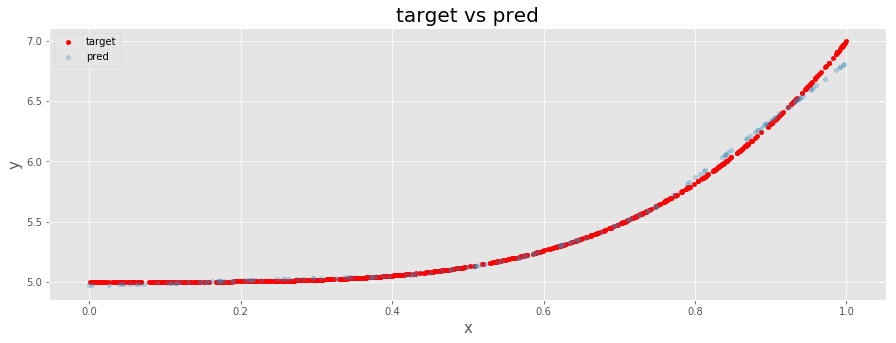

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='x', y='y', ax=axes, color='red')
# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)
# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best');

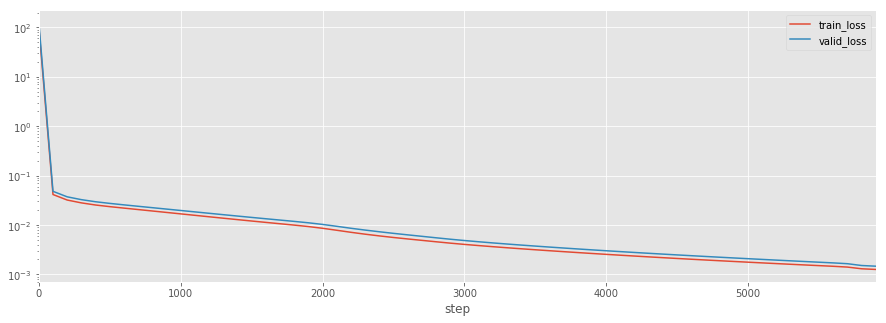

In [19]:
df_loss.set_index('step').plot(logy=True, figsize=(15,5));